In [92]:
import numpy as np
import pandas as pd

# 第一道大题

# 题目分析

本题的任务有两个，一个是建立预剪枝的决策树，本题用过去作业的代码进行编写，完成了如下内容：

1.完成了决策树的编写

2.基于信息增益进行选择特征

3.可视化，由于中文无法显示，换成了英文

4.测试数据的准确率

该程序没有完成事项：预剪枝编写

# 决策树绘图代码

In [93]:
import matplotlib.pyplot as plt

# 设置决策节点和叶节点的边框形状、边距和透明度，以及箭头的形状
decisionNode = dict(boxstyle="square,pad=0.5", fc="0.9")
leafNode = dict(boxstyle="round4, pad=0.5", fc="0.9")
arrow_args = dict(arrowstyle="<-", connectionstyle="arc3", shrinkA=0,
                  shrinkB=16)


def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    newTxt = nodeTxt
    if type(nodeTxt).__name__ == 'tuple':
        newTxt = nodeTxt[0] + '\n'
        for strI in nodeTxt[1:-1]:
            newTxt += str(strI) + ','
        newTxt+= str(nodeTxt[-1])

    createPlot.ax1.annotate(newTxt, xy=parentPt,
                            xycoords='axes fraction',
                            xytext=centerPt, textcoords='axes fraction',
                            va="top", ha="center", bbox=nodeType,
                            arrowprops=arrow_args)


def getNumLeafs(myTree):
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            numLeafs += getNumLeafs(secondDict[key])
        else:
            numLeafs += 1
    return numLeafs


def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            thisDepth = 1 + getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        if thisDepth > maxDepth: maxDepth = thisDepth
    return maxDepth


def retrieveTree(i):
    listOfTrees = [
        {'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
        {'no surfacing': {0: 'no', 1: {
            'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
    ]
    return listOfTrees[i]


def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)





def createPlot(inTree):
    if isinstance(inTree,dict) == False:
        print("阈值设定过大，树没有生成")
    else:
        fig = plt.figure(1, facecolor='white',figsize=(15,15))

        fig.clf()
        axprops = dict(xticks=[], yticks=[])
        createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
        plotTree.totalW = float(getNumLeafs(inTree))
        plotTree.totalD = float(getTreeDepth(inTree)) + 0.5
        plotTree.xOff = -0.5 / plotTree.totalW
        plotTree.yOff = 1.0
        plotTree(inTree, (0.5, 1.0), '')
        plt.show()

# 计算信息熵

In [94]:
from math import log
import operator
import os

import re
from numpy import inf
import copy


# 计算信息熵
def calcShannonEnt(dataSet, labelIndex):
    # type: (list) -> float
    numEntries = 0  # 样本数(按权重计算）
    labelCounts = {}
    for featVec in dataSet:  # 遍历每个样本
        if featVec[labelIndex] != 'N':
            weight = float(featVec[-2])
            numEntries += weight
            currentLabel = featVec[-1]  # 当前样本的类别
            if currentLabel not in labelCounts.keys():  # 生成类别字典
                labelCounts[currentLabel] = 0
            labelCounts[currentLabel] += weight  # 数据集的倒数第二个值用来标记样本权重
    shannonEnt = 0.0
    for key in labelCounts:  # 计算信息熵
        prob = float(labelCounts[key]) / numEntries
        shannonEnt = shannonEnt - prob * log(prob, 2)
    return shannonEnt

# 生成决策树

In [95]:


def splitDataSet(dataSet, axis, value, LorR='N'):
    """
    type: (list, int, string or float, string) -> list
    划分数据集
    axis:按第几个特征划分
    value:划分特征的值
    LorR: N 离散属性; L 小于等于value值; R 大于value值
    """
    retDataSet = []
    featVec = []
    if LorR == 'N':  # 离散属性
        for featVec in dataSet:
            if featVec[axis] == value:
                reducedFeatVec = featVec[:axis]
                reducedFeatVec.extend(featVec[axis + 1:])
                retDataSet.append(reducedFeatVec)
    elif LorR == 'L':
        for featVec in dataSet:
            if featVec[axis] != 'N':
                if float(featVec[axis]) < value:
                    retDataSet.append(featVec)
    elif LorR == 'R':
        for featVec in dataSet:
            if featVec[axis] != 'N':
                if float(featVec[axis]) > value:
                    retDataSet.append(featVec)
    return retDataSet




def calcTotalWeight(dataSet, labelIndex, isContainNull):
    """
    type: (list, int, bool) -> float
    计算样本集对某个特征值的总样本树（按权重计算）
    :param dataSet: 数据集
    :param labelIndex: 特征值索引
    :param isContainNull: 是否包含空值的样本
    :return: 返回样本集的总权重值
    """
    totalWeight = 0.0
    for featVec in dataSet:  # 遍历每个样本
        weight = float(featVec[-2])
        if isContainNull is False and featVec[labelIndex] != 'N':
            totalWeight += weight  # 非空样本树，按权重计算
        if isContainNull is True:
            totalWeight += weight  # 总样本数，按权重计算
    return totalWeight


def calcGain(dataSet, labelIndex, labelPropertyi):
    """
    type: (list, int, int) -> float, int
    计算信息增益,返回信息增益值和连续属性的划分点
    dataSet: 数据集
    labelIndex: 特征值索引
    labelPropertyi: 特征值类型，0为离散，1为连续
    """
    baseEntropy = calcShannonEnt(dataSet, labelIndex)  # 计算根节点的信息熵
    featList = [example[labelIndex] for example in dataSet]  # 特征值列表
    uniqueVals = set(featList)  # 该特征包含的所有值
    bestPartValuei = None
    newEntropy = 0.0
    totalWeight = 0.0
    totalWeightV = 0.0
    totalWeight = calcTotalWeight(dataSet, labelIndex, True)  # 总样本权重
    totalWeightV = calcTotalWeight(dataSet, labelIndex, False)  # 非空样本权重
    if labelPropertyi == 0:  # 对离散的特征
        for value in uniqueVals:  # 对每个特征值，划分数据集, 计算各子集的信息熵
            if value != 'N':
                subDataSet = splitDataSet(dataSet, labelIndex, value)
                totalWeightSub = 0.0
                totalWeightSub = calcTotalWeight(subDataSet, labelIndex, True)
                prob = totalWeightSub / totalWeightV
                newEntropy += prob * calcShannonEnt(subDataSet, labelIndex)
    else:  # 对连续的特征
        uniqueValsList = list(uniqueVals)
        if 'N' in uniqueValsList:
            uniqueValsList.remove('N')
        sortedUniqueVals = sorted(uniqueValsList)  # 对特征值排序
        listPartition = []
        minEntropy = inf
        if len(sortedUniqueVals) == 1:  # 如果只有一个值，可以看作只有左子集，没有右子集
            totalWeightLeft = calcTotalWeight(dataSet, labelIndex, True)
            probLeft = totalWeightLeft / totalWeightV
            minEntropy = probLeft * calcShannonEnt(dataSet, labelIndex)
        else:
            for j in range(len(sortedUniqueVals) - 1):  # 计算划分点
                partValue = (float(sortedUniqueVals[j]) + float(
                    sortedUniqueVals[j + 1])) / 2
                # 对每个划分点，计算信息熵
                dataSetLeft = splitDataSet(dataSet, labelIndex, partValue, 'L')
                dataSetRight = splitDataSet(dataSet, labelIndex, partValue, 'R')
                totalWeightLeft = 0.0
                totalWeightLeft = calcTotalWeight(dataSetLeft, labelIndex, True)
                totalWeightRight = 0.0
                totalWeightRight = calcTotalWeight(dataSetRight, labelIndex, True)
                probLeft = totalWeightLeft / totalWeightV
                probRight = totalWeightRight / totalWeightV
                Entropy = probLeft * calcShannonEnt(dataSetLeft, labelIndex) + \
                          probRight * calcShannonEnt(dataSetRight, labelIndex)
                if Entropy < minEntropy:  # 取最小的信息熵
                    minEntropy = Entropy
                    bestPartValuei = partValue
        newEntropy = minEntropy
    gain = totalWeightV / totalWeight * (baseEntropy - newEntropy)
    return gain, bestPartValuei




# 选择最好的数据集划分方式
def chooseBestFeatureToSplit(dataSet, labelProperty, minaddEnt):
    """
    type: (list, int) -> int, float
    :param dataSet: 样本集
    :param labelProperty: 特征值类型，1 连续， 0 离散
    :param minaddEnt: 预剪枝设定增益阈值
    :return: 最佳划分属性的索引和连续属性的划分值
    """
    numFeatures = len(labelProperty)  # 特征数
    bestInfoGain = 0.0
    bestFeature = -1
    bestPartValue = None  # 连续的特征值，最佳划分值

    for i in range(numFeatures):  # 对每个特征循环
        infoGain, bestPartValuei = calcGain(dataSet, i, labelProperty[i])
        if infoGain > (bestInfoGain + minaddEnt):#超过增益阈值后才生成结点
            bestInfoGain = infoGain
            bestFeature = i
            bestPartValue = bestPartValuei
            
    print("信息增益为：",bestInfoGain)
    return bestFeature, bestPartValue


# 通过排序返回出现次数最多的类别
def majorityCnt(classList, weightList):
    classCount = {}
    for i in range(len(classList)):
        if classList[i] not in classCount.keys():
            classCount[classList[i]] = 0.0
        classCount[classList[i]] += round(float(weightList[i]),1)

    # python 2.7
    # sortedClassCount = sorted(classCount.iteritems(),
    #                         key=operator.itemgetter(1), reverse=True)
    sortedClassCount = sorted(classCount.items(),
                              key=operator.itemgetter(1), reverse=True)
    if len(sortedClassCount) == 1:
        return (sortedClassCount[0][0],sortedClassCount[0][1],0.0)
    return (sortedClassCount[0][0], sortedClassCount[0][1], sortedClassCount[1][1])



# 测试算法，用于predict

def classify(inputTree, classList, featLabels, featLabelProperties, testVec):
    """
    :param inputTree: 输入的决策树
    :param classList: 类别集合
    :param testVec: 测试样本
    :param featlabels: 样本特征标签
    :param featlabelProperties: 特征值类型，1 连续， 0 离散
    :return: 决策树给出的类别
    """
    firstStr = list(inputTree.keys())[0]  # 根节点
    firstLabel = firstStr
    lessIndex = str(firstStr).find('<')
    if lessIndex > -1:  # 如果是连续型的特征
        firstLabel = str(firstStr)[:lessIndex]
    secondDict = inputTree[firstStr]
    featIndex = featLabels.index(firstLabel)  # 跟节点对应的特征
    #classLabel = {}
    #for classI in classList:
        #classLabel[classI] = 0.0
    for key in secondDict.keys():  # 对每个分支循环
        if featLabelProperties[featIndex] == 0:  # 离散的特征
            if testVec[featIndex] == key:  # 测试样本进入某个分支
                if type(secondDict[key]).__name__ == 'dict':  # 该分支不是叶子节点，递归
                    return classify(secondDict[key], classList, featLabels,
                                          featLabelProperties, testVec)
                    
                else:  # 如果是叶子， 返回结果
                    return secondDict[key][0]
                    
            
        else:
            partValue = float(str(firstStr)[lessIndex + 1:])
            
            if float(testVec[featIndex]) <= partValue and key == 'Y':  # 进入左子树
                if type(secondDict['Y']).__name__ == 'dict':  # 该分支不是叶子节点，递归
                    return  classify(secondDict['Y'], classList, featLabels,
                                             featLabelProperties, testVec)
                    
                else:  # 如果是叶子， 返回结果
                    return secondDict[key][0]
                    
            elif float(testVec[featIndex]) > partValue and key == 'N':
                if type(secondDict['N']).__name__ == 'dict':  # 该分支不是叶子节点，递归
                    return  classify(secondDict['N'], classList, featLabels,
                                             featLabelProperties, testVec)
                    
                else:  # 如果是叶子， 返回结果
                    return secondDict[key][0]
                    

    return 0




# 准确率测试

In [96]:
def cal_accuracy(inputTree, classList, featLabels, featLabelProperties, testdata):
    """
    :param inputTree: 输入的决策树
    :param testdata: 测试集
    :param featlabels: 样本特征标签
    :param featlabelProperties: 特征值类型，1 连续， 0 离散
    :return: 准确率
    """
    if isinstance(inputTree,dict) == False:
        print("输入的树为空或者格式不为字典,无法判断")
        return 0
    else:
        n=len(testdata)
        y_truelist = [example[-1] for example in testdata] #提取测试样本类别
        y_predictlist=[]#储存测试样本预测类别
        for i in range(n):
            temp=classify(inputTree, classList, featLabels, featLabelProperties, testdata[i])
            y_predictlist.append(temp)
        
        #循环计算误判数目
        err=0
        for i in range(n):
            if y_truelist[i]!=y_predictlist[i]:
                err+=1

        return 1-float(err/n)

# 主函数

信息增益为： 0.36298956253708536
信息增益为： 0.31668908831502096
信息增益为： 0.3219280948873623
信息增益为： 1.0
信息增益为： 0.3219280948873623
信息增益为： 1.0


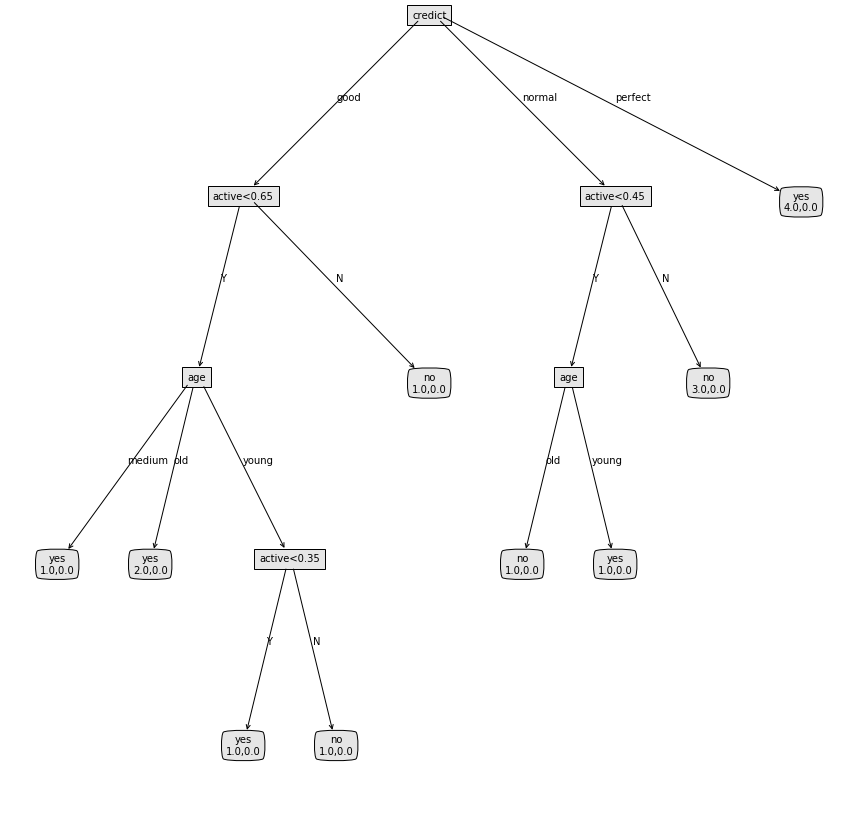

In [97]:
fr = open(r'ml_train.txt',encoding='utf-8')
# 生成数据集
lDataSet = [inst.strip().split('\t') for inst in fr.readlines()]
# 样本特征标签
labels = ['age','credict','active']
# 样本特征类型，0为离散，1为连续
labelProperties = [0, 0, 1]
# 类别向量
classList = ['yes', 'no']
# 验证集
#dataSet_test = [['rain', '72', '95', 'false', 1, 'Don’t Play'], ['rain', '72', '90', 'true', 1, 'Play']]

#设定增益阈值,用于基础预剪枝，若阈值过大则无法生成树
minaddEnt = 0
# 构建决策树
trees = createTree(lDataSet, labels, labelProperties,minaddEnt)

# 绘制决策树
createPlot(trees)


In [98]:

# 测试样本
fr = open(r'ml_test.txt',encoding='utf-8')
lDataSet = [inst.strip().split('\t') for inst in fr.readlines()]

accuracy=cal_accuracy(trees, classList, labels, labelProperties,lDataSet)
print("测试集准确率是%.2f"%accuracy)


测试集准确率是0.50


# 输出分析

